# 2022-02-21 QR Retrospective

## Last time

* Performance strategies
* Right vs left-looking algorithms
* Elementary reflectors

## Today

* Householder QR
* Comparison of interfaces
* Profiling
* Cholesky QR

In [20]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

gram_schmidt_classical (generic function with 1 method)

# Householder QR

Gram-Schmidt constructed a triangular matrix $R$ to orthogonalize $A$ into $Q$. Each step was a projector, which is a rank-deficient operation. Householder uses orthogonal transformations (reflectors) to triangularize.

$$ \underbrace{Q_{n} \dotsb Q_1}_{Q^T} A = R $$

The structure of the algorithm is

$$ \underbrace{\begin{bmatrix} * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ \end{bmatrix}}_{A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ \end{bmatrix}}_{Q_1 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & * \\ 0 & 0 & * \\ \end{bmatrix}}_{Q_2 Q_1 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ \end{bmatrix}}_{Q_3 Q_2 Q_1 A}
$$

# Constructing the $Q_j$

$$ \underbrace{Q_{n} \dotsb Q_1}_{Q^T} A = R $$

Each of our $Q_j$ will have the form
$$Q_j = \begin{bmatrix} I_i & 0 \\ 0 & F \end{bmatrix}$$
where $F$ is a "reflection" that achieves
$$ F x = \begin{bmatrix} \lVert x \rVert \\ 0 \\ 0 \\ \vdots \end{bmatrix} $$
where $x$ is the column of $R$ from the diagonal down.
This transformation is a reflection across a plane with normal $v = Fx - x = \lVert x \rVert e_1 - x$.

![Householder Reflector (Trefethen and Bau, 1999)](../img/TB-Householder.png)

The reflection, as depicted above by Trefethen and Bau (1999) can be written $F = I - 2 \frac{v v^T}{v^T v}$.

# Adventures in reflection

In [74]:
A = rand(4, 4); A += A'
v = copy(A[:,1])
v[1] -= norm(v)
v = normalize(v)
F = I - 2 * v * v'
B = F * A

4×4 Matrix{Float64}:
 2.60433      2.36089   1.70012    2.01843
 1.10168e-16  1.17304   0.970666   0.181717
 2.13887e-16  0.56295   0.0443916  0.84314
 1.51129e-16  0.334055  1.30142    0.615434

In [22]:
v = copy(B[2:end, 2])
v[1] -= norm(v); v = normalize(v)
F = I - 2 * v * v'
B[2:end, 2:end] = F * B[2:end, 2:end]
B

4×4 Matrix{Float64}:
  1.57236       1.30985       1.71012    1.94193
 -2.12968e-16   0.862657      0.432445   1.07707
 -8.25206e-17  -5.55112e-17  -0.227314  -0.0211876
 -8.76049e-17   2.77556e-17  -0.270377  -0.369496

# An algorithm

In [75]:
function qr_householder_naive(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] -= norm(v)
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * (v' * R[j:end,j:end])
        push!(V, v)
    end
    V, R
end

qr_householder_naive (generic function with 1 method)

In [80]:
m = 4
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder_naive(A)
_, R_ = qr(A)
R_

4×4 Matrix{Float64}:
 -2.0  0.0      -1.11111      0.0
  0.0  1.49071   1.38778e-17  1.3582
  0.0  0.0       0.888889     9.71445e-17
  0.0  0.0       0.0          0.397523

# How to interpret $V$ as $Q$?

In [85]:
function reflectors_mult(V, x)
    y = copy(x)
    for v in reverse(V)
        n = length(v) - 1
        y[end-n:end] -= 2 * v * (v' * y[end-n:end])
    end
    y
end

function reflectors_to_dense(V)
    m = length(V[1])
    Q = diagm(ones(m))
    for j in 1:m
        Q[:,j] = reflectors_mult(V, Q[:,j])
    end
    Q
end

reflectors_to_dense (generic function with 1 method)

In [86]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder_naive(A)
Q = reflectors_to_dense(V)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 3.7994490775439526e-15
norm(Q * R - A) = 7.562760794606217e-15


# Great, but we can still break it

In [97]:
A = [1 0; 1e-4 1.]
V, R = qr_householder_naive(A)
R

2×2 Matrix{Float64}:
  1.0          0.0001
 -3.57747e-13  1.0

We had the lines

```julia
    v = copy(R[j:end, j])
    v[1] -= norm(v)
    v = normalize(v)
```
What happens when `R` is already upper triangular?

![Choosing the better of two Householder reflectors (Trefethen and Bau, 1999).](../img/TB-Householder2.png)

# An improved algorithm



In [98]:
function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # <---
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * v' * R[j:end,j:end]
        push!(V, v)
    end
    V, R
end

qr_householder (generic function with 1 method)

In [99]:
A = [2 -1; -1 2] * 1e-10
V, R = qr_householder(A)
tau = [2*v[1]^2 for v in V]
@show tau
V1 = [v ./ v[1] for v in V]
@show V1
R

tau = [1.894427190999916, 2.0]
V1 = [[1.0, -0.2360679774997897], [1.0]]


2×2 Matrix{Float64}:
 -2.23607e-10   1.78885e-10
 -1.29247e-26  -1.34164e-10

# Householder is backward stable

In [100]:
m = 40
x = LinRange(-1, 1, m)
A = vander(x, m)
V, R = qr_householder(A)
Q = reflectors_to_dense(V)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 5.949301496893686e-15
norm(Q * R - A) = 1.2090264267288813e-14


In [104]:
A = [1 0; 0 1.]
V, R = qr_householder(A)
qr(A)

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}}
Q factor:
2×2 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}}:
 1.0  0.0
 0.0  1.0
R factor:
2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

# Orthogonality is preserved

norm(v) = 1.4245900685395503


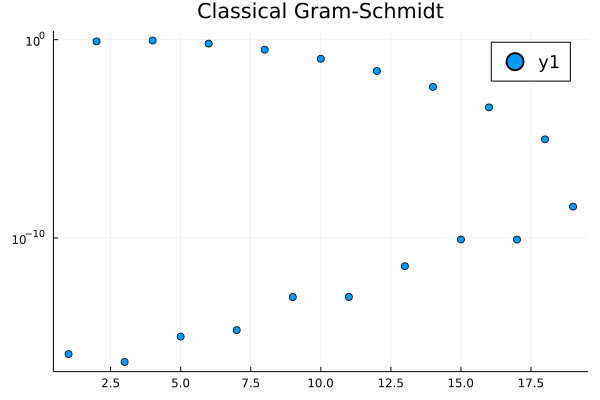

In [105]:
x = LinRange(-1, 1, 20)
A = vander(x)
Q, _ = gram_schmidt_classical(A)
v = A[:,end]
@show norm(v)
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10, title="Classical Gram-Schmidt")

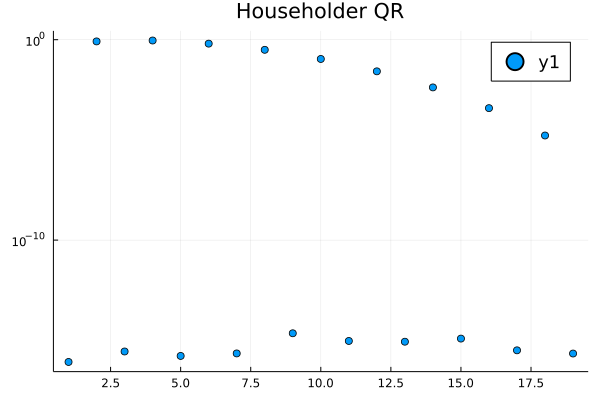

In [106]:
Q = reflectors_to_dense(qr_householder(A)[1])
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10, title="Householder QR")

# Composition of reflectors

\begin{align}
(I - 2 v v^T) (I - 2 w w^T) &= I - 2 v v^T - 2 w w^T + 4 v (v^T w) w^T \\
&= I - \Bigg[v \Bigg| w \Bigg] \begin{bmatrix} 2 & -4 v^T w \\ 0 & 2 \end{bmatrix} \begin{bmatrix} v^T \\ w^T \end{bmatrix}
\end{align}

This turns applying reflectors from a sequence of vector operations to a sequence of (smallish) matrix operations. It's the key to high performance and the native format (`QRCompactWY`) returned by Julia `qr()`.

In [34]:
Q, R = qr(A)

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}}
Q factor:
20×20 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}}:
 -0.223607  -0.368394   -0.430192    0.437609   …  -3.23545e-5   -5.31905e-6
 -0.223607  -0.329616   -0.294342    0.161225       0.000550027   0.000101062
 -0.223607  -0.290838   -0.173586   -0.0383868     -0.00436786   -0.000909558
 -0.223607  -0.252059   -0.067925   -0.170257       0.0214511     0.00515416
 -0.223607  -0.213281    0.0226417  -0.243417      -0.0726036    -0.0206167
 -0.223607  -0.174503    0.0981139  -0.266901   …   0.178209      0.06185
 -0.223607  -0.135724    0.158492   -0.24974       -0.323416     -0.144317
 -0.223607  -0.0969458   0.203775   -0.200966       0.429021      0.268016
 -0.223607  -0.0581675   0.233964   -0.129612      -0.386119     -0.402025
 -0.223607  -0.0193892   0.249058   -0.0447093      0.157308      0.491364
 -0.223607   0.0193892   0.249058    0.0447093  …   0.157308     -0.491364
 -0.223607   0.0581675   0.233964    0.1296

# This works even for very nonsquare matrices

In [107]:
A = rand(1000000, 5)
Q, R = qr(A)
@show size(Q)
@show norm(Q*R - A)
R

size(Q) = (1000000, 1000000)
norm(Q * R - A) = 1.3061794499648251e-12


5×5 Matrix{Float64}:
 -577.124  -432.904  -433.171  -432.588  -432.67
    0.0    -382.047  -163.951  -164.018  -163.912
    0.0       0.0     345.021   103.218   103.383
    0.0       0.0       0.0     329.294    75.2444
    0.0       0.0       0.0       0.0     320.426

This is known as a "full" (or "complete") QR factorization, in contrast to a reduced QR factorization in which $Q$ has the same shape as $A$.
* How much memory does $Q$ use?

# Compare to [`numpy.linalg.qr`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html)

* Need to decide up-front whether you want full or reduced QR.
* Full QR is expensive to represent.

# Cholesky QR

$$ R^T R = (QR)^T QR = A^T A$$

so we should be able to use $L L^T = A^T A$ and then $Q = A L^{-T}$.

In [38]:
function qr_chol(A)
    R = cholesky(A' * A).U
    Q = A / R
    Q, R
end

A = rand(10,4)
Q, R = qr_chol(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 4.0080210542206936e-15
norm(Q * R - A) = 2.6083227424051477e-16


2.6083227424051477e-16

In [42]:
x = LinRange(-1, 1, 15)
A = vander(x)
Q, R = qr_chol(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 4.319941621565765e-6
norm(Q * R - A) = 7.58801405234759e-16


# Can we fix this?

Note that the product of two triangular matrices is triangular.

In [43]:
R = triu(rand(5,5))
R * R

5×5 Matrix{Float64}:
 0.937018  0.166589  1.28394   0.856513  1.91001
 0.0       0.147171  0.422197  0.410025  1.03557
 0.0       0.0       0.466456  0.381229  0.947622
 0.0       0.0       0.0       0.690276  0.506928
 0.0       0.0       0.0       0.0       0.0989786

In [47]:
function qr_chol2(A)
    Q, R = qr_chol(A)
    Q, R1 = qr_chol(Q)
    Q, R1 * R
end

x = LinRange(-1, 1, 15)
A = vander(x)
Q, R = qr_chol2(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 1.062650593210405e-15
norm(Q * R - A) = 8.199069771042307e-16


# How fast are these methods?

In [68]:
m, n = 5000, 2000
A = randn(m, n)

@time qr(A);

  1.236501 seconds (7 allocations: 77.393 MiB)


In [67]:
A = randn(m, n)
@time qr_chol(A);

  0.366707 seconds (10 allocations: 137.329 MiB)


# Profiling

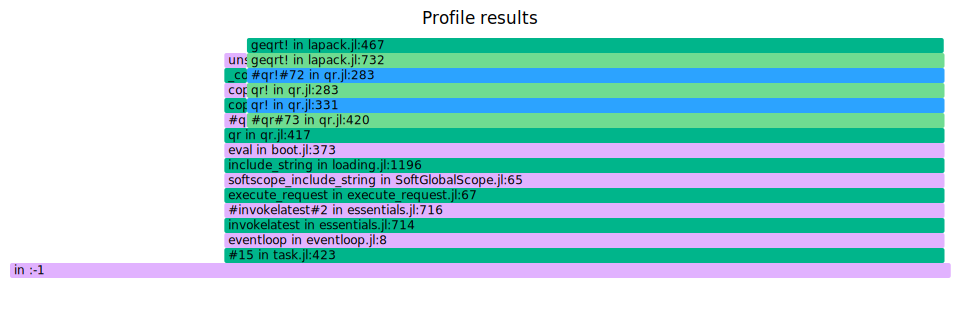

In [69]:
using ProfileSVG

@profview qr(A)